In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Load dataset
df = pd.read_csv('Amazon.csv')
print(df.shape)
print(df.head())
print(df.columns)
print(df.info())
print(df.isnull().sum())

(21223, 6)
   qid                                              query     item_id  \
0    0  I need filters that effectively trap dust and ...  B0C5QYYHTJ   
1    1  I need to find a protein that is super healthy...  B0C7D3VLXW   
2    2  I need a pillow that helps keep my nasal pillo...  B0C3QRMPVN   
3    3  I need a memory stick that is excellent and ex...  B0BC13TQJQ   
4    4  I want to buy something that my children will ...  B07Z86PHP8   

                        user_id  ori_rating  \
0  AGREO2G3GTRNYOJK4CIQV2DTZLSQ           5   
1  AFLIZT24MDW4XG4HBYKOI3BZGDHQ           5   
2  AFCSK3W3GI7PGT4655HHKZ2CFFMA           5   
3  AGGOTCPWSQFI5YHNDLNZ63ABWZVA           5   
4  AEIIPB3DNXXLZX4VRCSVREXGCXUA           5   

                                          ori_review  
0  These filters work I could not believe the amo...  
1  Love We love this protein we’ve been using it ...  
2  CPAP help I use this pillow nightly with my CP...  
3  Excellent. More than expected Memory stick i

Total records: 21223
Unique users: 20838
Unique items: 20463
ori_rating
5    21223
Name: count, dtype: int64


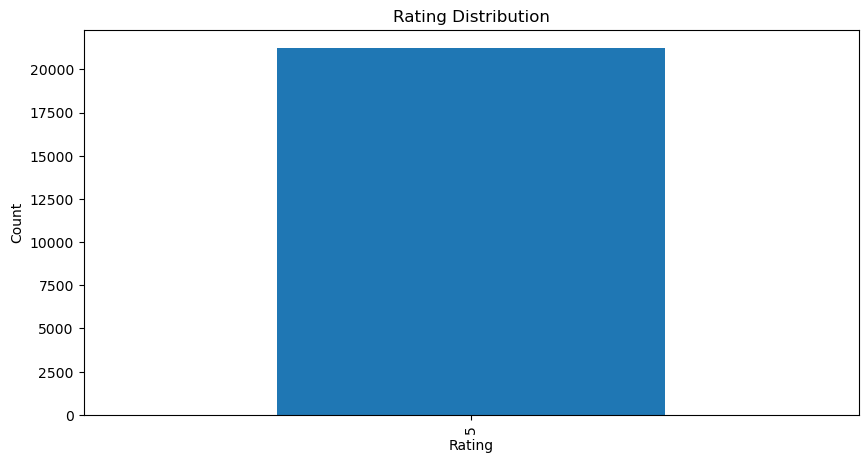

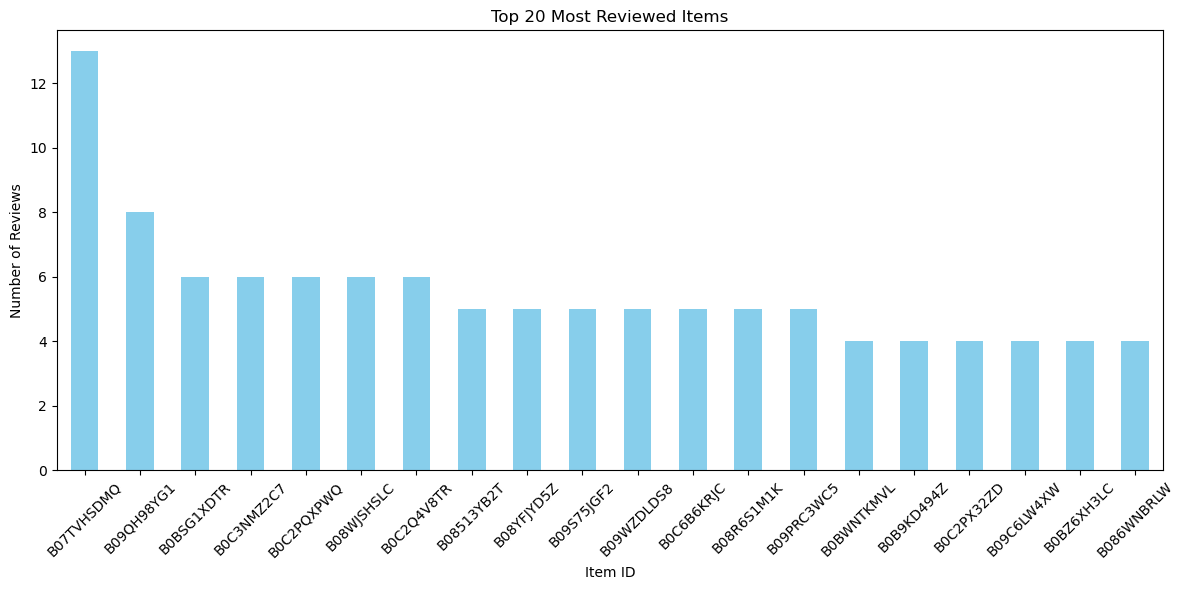

In [3]:
print(f"Total records: {len(df)}")
print(f"Unique users: {df['user_id'].nunique()}")
print(f"Unique items: {df['item_id'].nunique()}")

print(df['ori_rating'].value_counts())

# Rating distribution
plt.figure(figsize=(10, 5))
df['ori_rating'].value_counts().plot(kind='bar')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Top 20 most reviewed items
item_counts = df['item_id'].value_counts().head(20)
plt.figure(figsize=(12, 6))
item_counts.plot(kind='bar', color='skyblue')
plt.title('Top 20 Most Reviewed Items')
plt.xlabel('Item ID')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
# Keep relevant columns and rename
df = df[['user_id', 'item_id', 'query', 'ori_review', 'ori_rating']].copy()
df.columns = ['user_id', 'item_id', 'query', 'review', 'rating']

# Drop missing values
df = df.dropna()
print(df.head())

                        user_id     item_id  \
0  AGREO2G3GTRNYOJK4CIQV2DTZLSQ  B0C5QYYHTJ   
1  AFLIZT24MDW4XG4HBYKOI3BZGDHQ  B0C7D3VLXW   
2  AFCSK3W3GI7PGT4655HHKZ2CFFMA  B0C3QRMPVN   
3  AGGOTCPWSQFI5YHNDLNZ63ABWZVA  B0BC13TQJQ   
4  AEIIPB3DNXXLZX4VRCSVREXGCXUA  B07Z86PHP8   

                                               query  \
0  I need filters that effectively trap dust and ...   
1  I need to find a protein that is super healthy...   
2  I need a pillow that helps keep my nasal pillo...   
3  I need a memory stick that is excellent and ex...   
4  I want to buy something that my children will ...   

                                              review  rating  
0  These filters work I could not believe the amo...       5  
1  Love We love this protein we’ve been using it ...       5  
2  CPAP help I use this pillow nightly with my CP...       5  
3  Excellent. More than expected Memory stick is ...       5  
4  My children love these! My son asked me to pur...       5  


In [5]:
# Convert text to lowercase and combine
df['query'] = df['query'].str.lower()
df['review'] = df['review'].str.lower()
df['combined'] = df['query'] + ' ' + df['review']
print(df.head())

                        user_id     item_id  \
0  AGREO2G3GTRNYOJK4CIQV2DTZLSQ  B0C5QYYHTJ   
1  AFLIZT24MDW4XG4HBYKOI3BZGDHQ  B0C7D3VLXW   
2  AFCSK3W3GI7PGT4655HHKZ2CFFMA  B0C3QRMPVN   
3  AGGOTCPWSQFI5YHNDLNZ63ABWZVA  B0BC13TQJQ   
4  AEIIPB3DNXXLZX4VRCSVREXGCXUA  B07Z86PHP8   

                                               query  \
0  i need filters that effectively trap dust and ...   
1  i need to find a protein that is super healthy...   
2  i need a pillow that helps keep my nasal pillo...   
3  i need a memory stick that is excellent and ex...   
4  i want to buy something that my children will ...   

                                              review  rating  \
0  these filters work i could not believe the amo...       5   
1  love we love this protein we’ve been using it ...       5   
2  cpap help i use this pillow nightly with my cp...       5   
3  excellent. more than expected memory stick is ...       5   
4  my children love these! my son asked me to pur...       5

In [6]:
# Group by item_id
items = df.groupby('item_id')['query'].apply(' '.join).reset_index()
items.columns = ['item_id', 'all_queries']

reviews = df.groupby('item_id')['review'].apply(' '.join).reset_index()
reviews.columns = ['item_id', 'all_reviews']

combined = df.groupby('item_id')['combined'].apply(' '.join).reset_index()
combined.columns = ['item_id', 'all_text']

ratings = df.groupby('item_id')['rating'].mean().reset_index()
ratings.columns = ['item_id', 'avg_rating']

# Merge all
items = items.merge(reviews, on='item_id')
items = items.merge(combined, on='item_id')
items = items.merge(ratings, on='item_id')
print(items.head())

      item_id                                        all_queries  \
0  0007582471  i'm looking for a modern makeover story that's...   
1  0060735880  i need to find a unique history book that is n...   
2  0061730793  i'm looking for a book with beautiful words an...   
3  0061900621  i am looking for a book for my two-year-old wh...   
4  0062124277  i'm looking for a great book, but i want to av...   

                                         all_reviews  \
0  witty and fun modern makeover story. there's a...   
1  out of print this is a terrific unique history...   
2  beautiful! this book has been wonderfully done...   
3  immediate hit with 2 yr old my newly minted tw...   
4  inspired as always great book, of course, but ...   

                                            all_text  avg_rating  
0  i'm looking for a modern makeover story that's...         5.0  
1  i need to find a unique history book that is n...         5.0  
2  i'm looking for a book with beautiful words an... 

In [7]:
# TF-IDF for queries
vectorizer_query = TfidfVectorizer(max_features=500, stop_words='english')
query_tfidf = vectorizer_query.fit_transform(items['all_queries'])
print(f"Query features: {query_tfidf.shape}")

# TF-IDF for reviews
vectorizer_review = TfidfVectorizer(max_features=500, stop_words='english')
review_tfidf = vectorizer_review.fit_transform(items['all_reviews'])
print(f"Review features: {review_tfidf.shape}")

# TF-IDF for combined text
vectorizer_all = TfidfVectorizer(max_features=1000, stop_words='english')
all_tfidf = vectorizer_all.fit_transform(items['all_text'])
print(f"Combined features: {all_tfidf.shape}")

Query features: (20463, 500)
Review features: (20463, 500)
Combined features: (20463, 1000)


In [8]:
# Cosine similarity
query_sim = cosine_similarity(query_tfidf)
query_similarity = pd.DataFrame(query_sim, index=items['item_id'], columns=items['item_id'])

review_sim = cosine_similarity(review_tfidf)
review_similarity = pd.DataFrame(review_sim, index=items['item_id'], columns=items['item_id'])

combined_sim = cosine_similarity(all_tfidf)
combined_similarity = pd.DataFrame(combined_sim, index=items['item_id'], columns=items['item_id'])

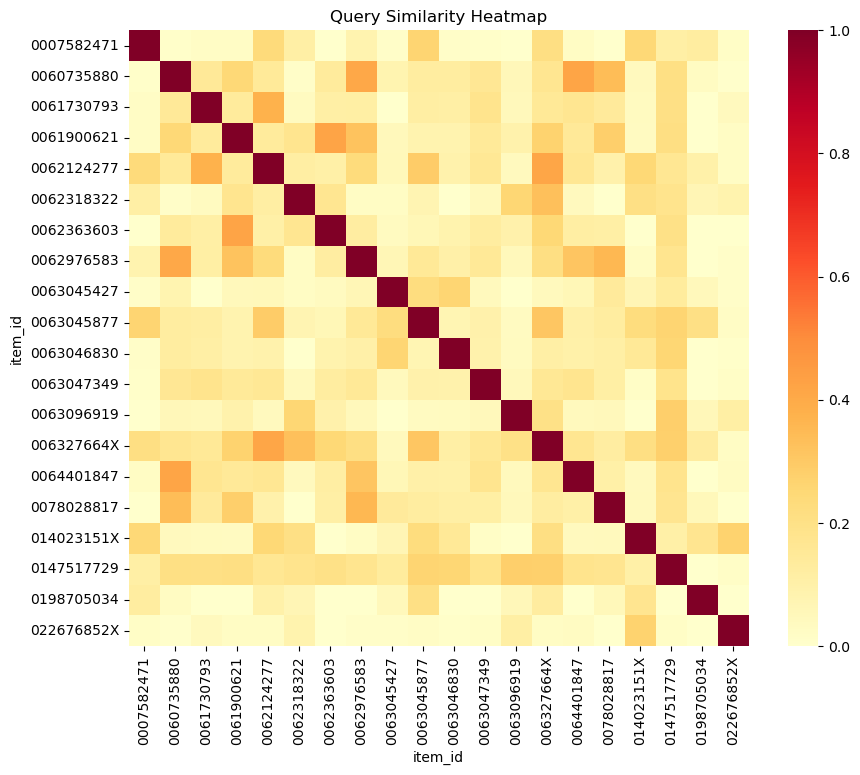

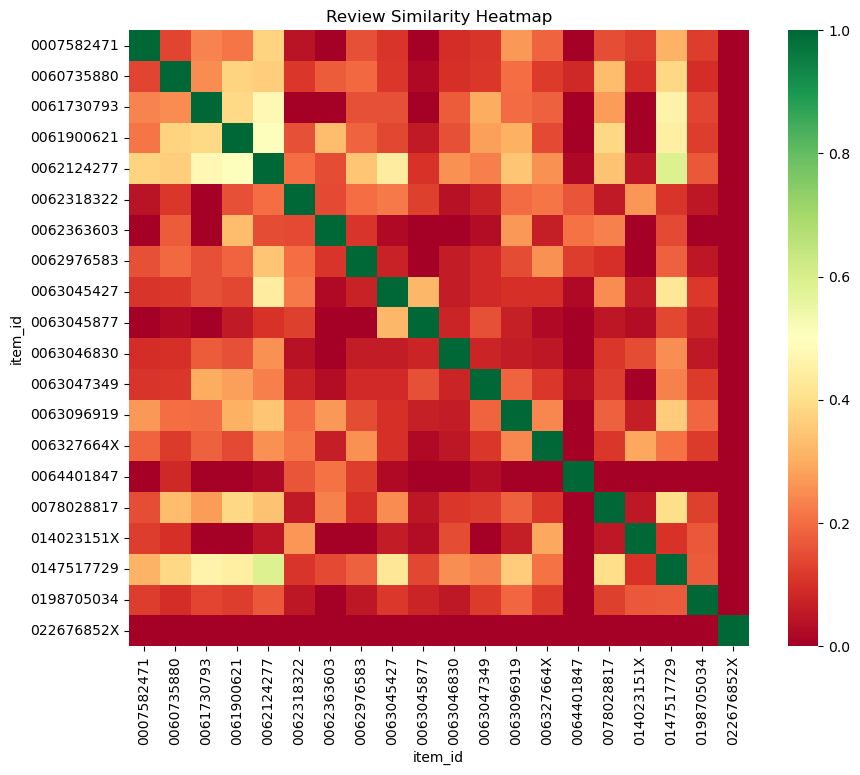

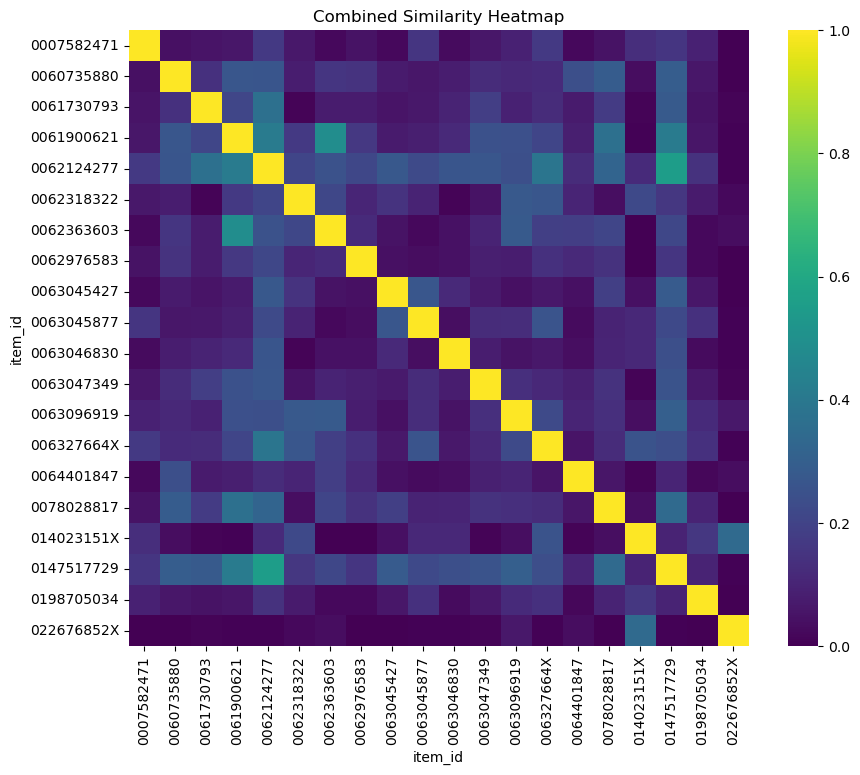

In [9]:
# Query similarity heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(query_similarity.iloc[:20, :20], cmap='YlOrRd')
plt.title('Query Similarity Heatmap')
plt.show()

# Review similarity heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(review_similarity.iloc[:20, :20], cmap='RdYlGn')
plt.title('Review Similarity Heatmap')
plt.show()

# Combined similarity heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(combined_similarity.iloc[:20, :20], cmap='viridis')
plt.title('Combined Similarity Heatmap')
plt.show()

In [10]:
# Query-based recommendation
def recommend_query(item_id, top_n=5):
    if item_id not in query_similarity.index:
        return pd.DataFrame()
    scores = query_similarity[item_id].sort_values(ascending=False)[1:top_n+1]
    return pd.DataFrame({'item_id': scores.index, 'score': scores.values})

# Review-based recommendation
def recommend_review(item_id, top_n=5):
    if item_id not in review_similarity.index:
        return pd.DataFrame()
    scores = review_similarity[item_id].sort_values(ascending=False)[1:top_n+1]
    return pd.DataFrame({'item_id': scores.index, 'score': scores.values})

# Hybrid recommendation
def recommend_hybrid(item_id, top_n=5):
    if item_id not in query_similarity.index:
        return pd.DataFrame()
    
    query_score = query_similarity[item_id]
    review_score = review_similarity[item_id]
    
    hybrid_score = 0.5 * query_score + 0.5 * review_score
    hybrid_score = hybrid_score.drop(item_id)
    
    top_items = hybrid_score.sort_values(ascending=False).head(top_n)
    return pd.DataFrame({'item_id': top_items.index, 'score': top_items.values})

In [11]:
test_item = items['item_id'].iloc[0]
print(f"Recommendations for: {test_item}")
print("Query-Based:")
print(recommend_query(test_item, 10))
print("Review-Based:")
print(recommend_review(test_item, 10))
print("Hybrid:")
print(recommend_hybrid(test_item, 10))

Recommendations for: 0007582471
Query-Based:
      item_id     score
0  B09RWNTLMR  0.845819
1  B0BJNBXVT7  0.842555
2  B08BX3QNQN  0.778375
3  0316353221  0.724992
4  B098J2FSFD  0.690276
5  B09RK45MWZ  0.676127
6  B09YL7LRTQ  0.672898
7  B0BQCWLNSX  0.670372
8  B08818YQB5  0.664260
9  B0CCCQZBKV  0.663932
Review-Based:
      item_id     score
0  B09YL7LRTQ  0.435273
1  B0B64FCB23  0.430814
2  B0BSTK5TPF  0.429613
3  B0BMJK31JY  0.424498
4  B0B2V7JWDV  0.423660
5  1492749788  0.412650
6  B0B6KX9152  0.412142
7  0593118200  0.410758
8  B0BSG1XDTR  0.408513
9  B091MQ9XHN  0.405814
Hybrid:
      item_id     score
0  B09YL7LRTQ  0.554085
1  B0BJNBXVT7  0.502883
2  B09RWNTLMR  0.491346
3  0316353221  0.487784
4  1728416701  0.466943
5  B0BQCWLNSX  0.455609
6  B0983KXF42  0.452246
7  B0B7KXL5CM  0.448279
8  B0B855H1J9  0.443354
9  B0B2V7JWDV  0.441036


In [12]:
query_top5 = recommend_query(test_item, 5)
review_top5 = recommend_review(test_item, 5)
hybrid_top5 = recommend_hybrid(test_item, 5)

comparison = pd.DataFrame({
    'Rank': range(1, 6),
    'Query': query_top5['item_id'].values,
    'Query_Score': query_top5['score'].values,
    'Review': review_top5['item_id'].values,
    'Review_Score': review_top5['score'].values,
    'Hybrid': hybrid_top5['item_id'].values,
    'Hybrid_Score': hybrid_top5['score'].values
})
print(comparison)

   Rank       Query  Query_Score      Review  Review_Score      Hybrid  \
0     1  B09RWNTLMR     0.845819  B09YL7LRTQ      0.435273  B09YL7LRTQ   
1     2  B0BJNBXVT7     0.842555  B0B64FCB23      0.430814  B0BJNBXVT7   
2     3  B08BX3QNQN     0.778375  B0BSTK5TPF      0.429613  B09RWNTLMR   
3     4  0316353221     0.724992  B0BMJK31JY      0.424498  0316353221   
4     5  B098J2FSFD     0.690276  B0B2V7JWDV      0.423660  1728416701   

   Hybrid_Score  
0      0.554085  
1      0.502883  
2      0.491346  
3      0.487784  
4      0.466943  


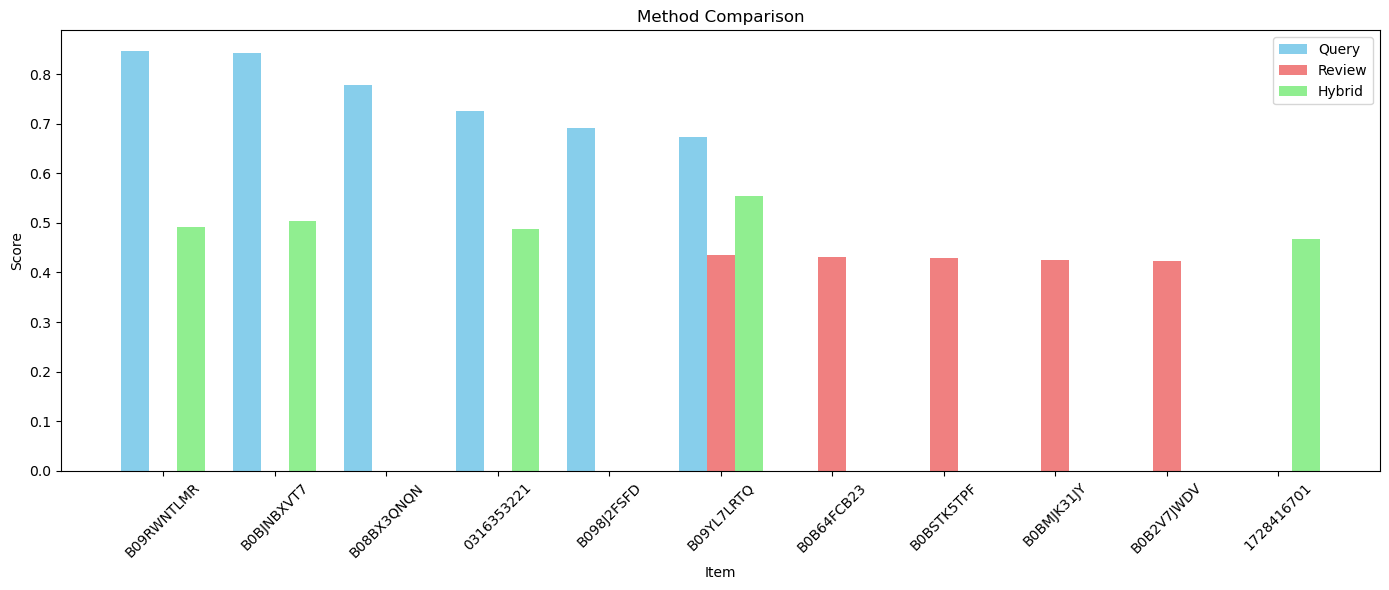

In [13]:
query_recs = recommend_query(test_item, 8)
review_recs = recommend_review(test_item, 8)
hybrid_recs = recommend_hybrid(test_item, 8)

all_items = pd.concat([
    query_recs['item_id'].head(5),
    review_recs['item_id'].head(5),
    hybrid_recs['item_id'].head(5)
]).unique()

plot_data = pd.DataFrame({
    'item': all_items,
    'query': [query_recs[query_recs['item_id']==i]['score'].values[0] if i in query_recs['item_id'].values else 0 for i in all_items],
    'review': [review_recs[review_recs['item_id']==i]['score'].values[0] if i in review_recs['item_id'].values else 0 for i in all_items],
    'hybrid': [hybrid_recs[hybrid_recs['item_id']==i]['score'].values[0] if i in hybrid_recs['item_id'].values else 0 for i in all_items]
})

x = np.arange(len(plot_data))
width = 0.25

plt.figure(figsize=(14, 6))
plt.bar(x - width, plot_data['query'], width, label='Query', color='skyblue')
plt.bar(x, plot_data['review'], width, label='Review', color='lightcoral')
plt.bar(x + width, plot_data['hybrid'], width, label='Hybrid', color='lightgreen')
plt.xlabel('Item')
plt.ylabel('Score')
plt.title('Method Comparison')
plt.xticks(x, [str(i)[:10] for i in plot_data['item']], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
def recommend_for_user(user_id, top_n=5):
    user_items = df[df['user_id'] == user_id]['item_id'].unique()
    if len(user_items) == 0:
        return pd.DataFrame()
    all_recs = pd.DataFrame()
    for item in user_items:
        recs = recommend_hybrid(item, 20)
        if not recs.empty:
            recs = recs[~recs['item_id'].isin(user_items)]
            all_recs = pd.concat([all_recs, recs])
    if all_recs.empty:
        return pd.DataFrame()
    final_recs = all_recs.groupby('item_id')['score'].max().sort_values(ascending=False).head(top_n)
    return pd.DataFrame({'item_id': final_recs.index, 'score': final_recs.values})

test_user = df['user_id'].iloc[0]
print(f"Recommendations for user: {test_user}")
print(recommend_for_user(test_user, 10))


Recommendations for user: AGREO2G3GTRNYOJK4CIQV2DTZLSQ
      item_id     score
0  B0C8J3GLGP  0.348989
1  B0C77Y7MDV  0.339100
2  B0C1ZWSGKT  0.328396
3  B01CWWAENG  0.313391
4  B08694X9QW  0.307339
5  B08CRKQ2V2  0.305093
6  B004BITLHA  0.300327
7  B09HNCZ9NB  0.291170
8  B01M3V2VMQ  0.287674
9  B07MBYFJ6T  0.286280


In [15]:
print("System Statistics:")
print(f"Total items: {len(items)}")
print(f"Average query similarity: {query_sim.mean():.4f}")
print(f"Average review similarity: {review_sim.mean():.4f}")

System Statistics:
Total items: 20463
Average query similarity: 0.0431
Average review similarity: 0.0376


In [16]:
all_recs = []
sample_items = items['item_id'].head(100)
for item in sample_items:
    recs = recommend_hybrid(item, 5)
    if not recs.empty:
        recs['source'] = item
        all_recs.append(recs)

results = pd.concat(all_recs, ignore_index=True)
results.to_csv('recommendations.csv', index=False)
print(f"Saved {len(results)} recommendations")
print(results.head(20))

Saved 500 recommendations
       item_id     score      source
0   B09YL7LRTQ  0.554085  0007582471
1   B0BJNBXVT7  0.502883  0007582471
2   B09RWNTLMR  0.491346  0007582471
3   0316353221  0.487784  0007582471
4   1728416701  0.466943  0007582471
5   1546026452  0.479963  0060735880
6   B0CF5FH6MC  0.400115  0060735880
7   B0B6XFT4RH  0.395717  0060735880
8   B00I828BD0  0.395017  0060735880
9   1581824874  0.389869  0060735880
10  B09CKH448Y  0.587020  0061730793
11  B0BL56Q9Z2  0.560447  0061730793
12  B0BCD1TMSP  0.536394  0061730793
13  B0C6MY6QT8  0.524618  0061730793
14  B0BD6V5GBS  0.521227  0061730793
15  1638070296  0.520446  0061900621
16  B00DGVFUJG  0.494088  0061900621
17  B0BQH4F8W8  0.492650  0061900621
18  B0C9RVM896  0.488718  0061900621
19  B0BMJK31JY  0.475959  0061900621
